In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.metrics import mean_squared_error

In [4]:
# Load the forward prediction model
forward_model = tf.keras.models.load_model("../models/80_neurons_1_layers_64_Batch_Size.keras")

In [5]:
shape = 328

# Initialize the back model
back_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(shape,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.RepeatVector(shape),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),  # Adding another LSTM layer
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(shape, activation='softmax'))
])

# Compile the model
back_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [6]:
def eval(pred, true):
    assert len(pred) != len(true)
    count = 0
    for i in range(pred.shape[0]):
        if pred[i].all() != true[i].all():
            count += 1
    return count

In [7]:
def convert_to_seq(arr):
    result = []
    error = 0
    for i in range(0, len(arr), 4):
        result.append(arr[i:i+4])
        for j in range(4):
            error += abs(arr[i+j] - int(arr[i+j]))

    return np.squeeze(np.array([result])), error

In [8]:
min_TX = -4.799135214
max_TX = 0

In [9]:
error = 0
count = 100
shape = 328

for i in range(count):
    input_value = random.uniform(min_TX, max_TX)
    repeated_X_test = np.repeat(input_value, shape).reshape(1, -1)
    pred_seq = back_model.predict(repeated_X_test)
    converted_seq, _ = convert_to_seq(pred_seq[0][0])
    pred_TX = forward_model.predict(np.array([converted_seq]))
    error += (input_value - pred_TX) ** 2

mse = error / count
print("Mean Squared Error: ", mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━

In [14]:
import sys
import os

class SuppressOutput:
    def __enter__(self):
        self.stdout_original = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self.stdout_original

In [17]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

# Training parameters
learning_rate = 0.001
num_epochs = 25000

# Initialize an empty list to store errors
errors = []

for layer in back_model.layers:
    back_model.trainable = True

for epoch in range(num_epochs):
    input_value = random.uniform(min_TX, max_TX)
    
    with tf.GradientTape() as tape:
        with SuppressOutput():
            pred_seq = back_model.predict(repeated_X_test)
            converted_seq, error = convert_to_seq(pred_seq[0][0])
            pred_TX = forward_model(np.array([converted_seq]))
            error += tf.reduce_mean(tf.square(input_value - pred_TX))
    
    gradients = tape.gradient(error, back_model.trainable_variables + forward_model.trainable_variables)
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    optimizer.apply_gradients(zip(gradients, back_model.trainable_variables + forward_model.trainable_variables))
    
    errors.append(error.numpy())  # Append error for this epoch

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {error.numpy():.4f}')
    
    # print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {error.numpy():.4f}')

Epoch 1/25000, Loss: 1.2213
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 419, in <genexpr>
    output_ta_t = tuple(  File "c:\Users\rsore\anaconda3\Lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Epoch 101/25000, Loss: 5.7817
Epoch 201/25000, Loss: 1.6727
Epoch 301/25000, Loss: 2.1589
Epoch 401/25000, Loss: 4.6294
Epoch 501/25000, Loss: 6.7170
Epoch 601/25000, Loss: 1.0533
Epoch 701/25000, Loss: 1.0043
Epoch 801/25000, Loss: 1.8953
Epoch 901/25000, Loss: 4.9171
Epoch 1001/25000, Loss: 5.0314
Epoch 1101/25000, Loss: 3.8459
Epoch 1201/25000, Loss: 4.9822
Epoch 1301/25000, Loss: 7.2252
Epoch 1401/25000, Loss: 1.9181
Epoc

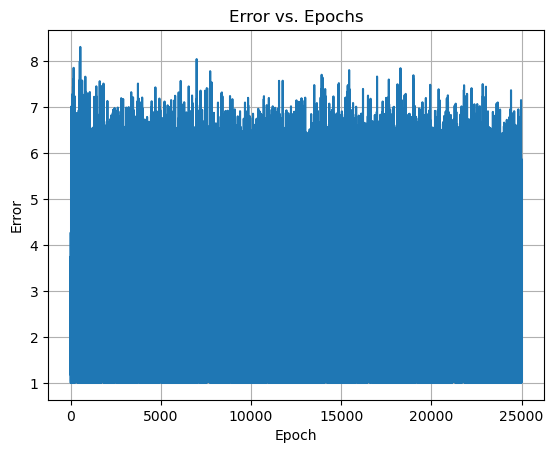

In [18]:
# Plot the error versus epochs
plt.plot(range(1, num_epochs + 1), errors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs. Epochs')
plt.grid(True)
plt.show()

In [19]:
error = 0
count = 100

for i in range(count):
    input_value = random.uniform(min_TX, max_TX)
    pred_seq = np.round(back_model.predict(np.array([[input_value]]))).astype(int)
    converted_seq = convert_to_seq(pred_seq[0])
    pred_TX = forward_model.predict(np.array([converted_seq]))
    se = np.mean((input_value - pred_TX) ** 2)
    error += se

mse = error / count
print("Mean Squared Error: ", mse)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\rsore\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\rsore\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\rsore\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\rsore\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\rsore\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\rsore\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\rsore\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\rsore\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\rsore\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\rsore\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\rsore\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\rsore\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\rsore\AppData\Local\Temp\ipykernel_27428\3911112480.py", line 6, in <module>

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 513, in predict

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 212, in one_step_on_data_distributed

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 201, in one_step_on_data

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 93, in predict_step

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 816, in __call__

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 42, in __call__

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 157, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 203, in call

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 188, in call

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 153, in _run_through_graph

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 572, in call

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 816, in __call__

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 118, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 42, in __call__

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 157, in error_handler

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py", line 141, in call

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\activations\activations.py", line 99, in static_call

  File "c:\Users\rsore\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 16, in relu

Matrix size-incompatible: In[0]: [1,1], In[1]: [328,64]
	 [[{{node sequential_1/dense_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_138763439]

In [ ]:
# save the model

back_model.save('trained_backward_pred.keras')